https://www.kaggle.com/code/saidakbarp/nyc-property-sales-eda-map-analysis

https://medium.com/@saidakbarp/interactive-map-visualization-with-folium-in-python-2e95544d8d9b

In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
#print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore")

# Data preprocessing

In [16]:
hsales = pd.read_csv('nyc-rolling-sales.csv') 

In [17]:
hsales.shape

(84548, 22)

In [18]:
# let's check what we have 
hsales.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


According to this official [page](https://www1.nyc.gov/assets/finance/downloads/pdf/07pdf/glossary_rsf071607.pdf), Ease-ment is "is a right, such as a right of way, which allows an entity to make limited use of another’s real property. For example: MTA railroad tracks that run across a portion of another property". Also, the Unnamed column is not mentioned and was likely used for iterating through records. So, those two columns are removed for now. 

In [19]:
hsales.drop(['Unnamed: 0', 'EASE-MENT'], axis=1, inplace=True)

In [20]:
hsales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         84548 non-null  int64 
 1   NEIGHBORHOOD                    84548 non-null  object
 2   BUILDING CLASS CATEGORY         84548 non-null  object
 3   TAX CLASS AT PRESENT            84548 non-null  object
 4   BLOCK                           84548 non-null  int64 
 5   LOT                             84548 non-null  int64 
 6   BUILDING CLASS AT PRESENT       84548 non-null  object
 7   ADDRESS                         84548 non-null  object
 8   APARTMENT NUMBER                84548 non-null  object
 9   ZIP CODE                        84548 non-null  int64 
 10  RESIDENTIAL UNITS               84548 non-null  int64 
 11  COMMERCIAL UNITS                84548 non-null  int64 
 12  TOTAL UNITS                     84548 non-null

It looks like empty records are not being treated as NA. We convert columns to their appropriate data types to obtain NAs.

In [21]:
#First, let's check which columns should be categorical
print('Column name')
for col in hsales.columns:
    if hsales[col].dtype=='object':
        print(col, hsales[col].nunique())

Column name
NEIGHBORHOOD 254
BUILDING CLASS CATEGORY 47
TAX CLASS AT PRESENT 11
BUILDING CLASS AT PRESENT 167
ADDRESS 67563
APARTMENT NUMBER 3989
LAND SQUARE FEET 6062
GROSS SQUARE FEET 5691
BUILDING CLASS AT TIME OF SALE 166
SALE PRICE 10008
SALE DATE 364


In [22]:
# LAND SQUARE FEET,GROSS SQUARE FEET, SALE PRICE, BOROUGH should be numeric. 
# SALE DATE datetime format.
# categorical: NEIGHBORHOOD, BUILDING CLASS CATEGORY, TAX CLASS AT PRESENT, BUILDING CLASS AT PRESENT,
# BUILDING CLASS AT TIME OF SALE, TAX CLASS AT TIME OF SALE,BOROUGH 

numer = ['LAND SQUARE FEET','GROSS SQUARE FEET', 'SALE PRICE', 'BOROUGH']
for col in numer: # coerce for missing values
    hsales[col] = pd.to_numeric(hsales[col], errors='coerce')

categ = ['NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'BUILDING CLASS AT PRESENT', 'BUILDING CLASS AT TIME OF SALE', 'TAX CLASS AT TIME OF SALE']
for col in categ:
    hsales[col] = hsales[col].astype('category')

hsales['SALE DATE'] = pd.to_datetime(hsales['SALE DATE'], errors='coerce')

Our dataset is ready for checking missing values.

In [23]:
missing = hsales.isnull().sum()/len(hsales)*100

print(pd.DataFrame([missing[missing>0],pd.Series(hsales.isnull().sum()[hsales.isnull().sum()>1000])], index=['percent missing','how many missing']))


                  LAND SQUARE FEET  GROSS SQUARE FEET   SALE PRICE
percent missing          31.049818          32.658372     17.22217
how many missing      26252.000000       27612.000000  14561.00000


Around 30% of GROSS SF and LAND SF are missing. Furthermore, around 17% of SALE PRICE is also missing. Below graph indicates which parts of the table are missing values in yellow.

<AxesSubplot: >

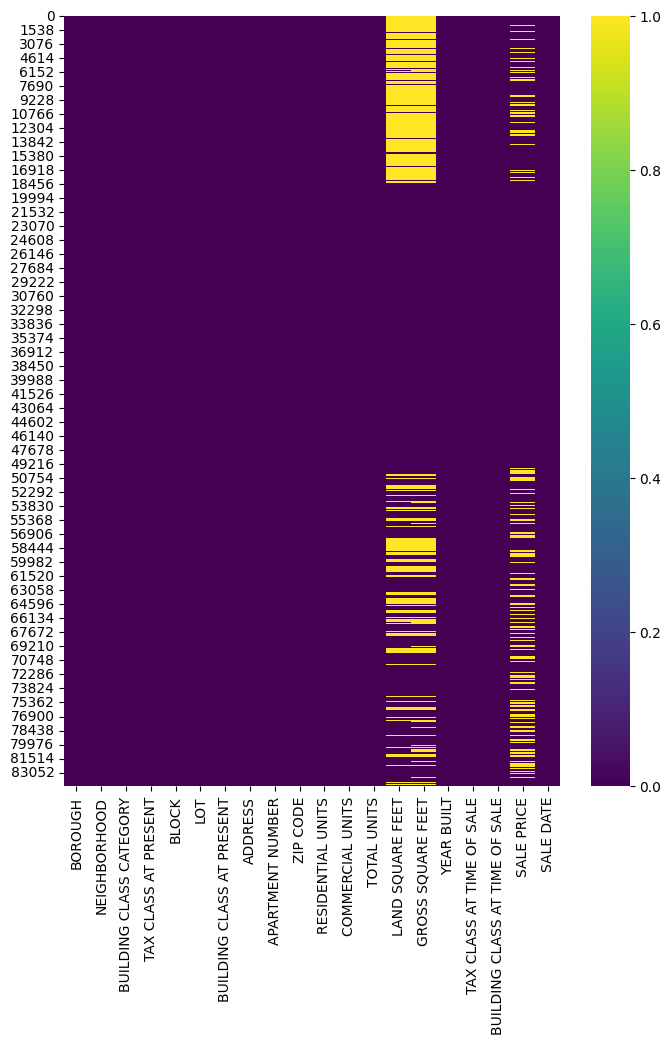

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(8,10))
sns.heatmap(hsales.isnull(),cmap='viridis')

Based on the missing values heatmap, we can see that some of the missing values in LAND SQUARE FEET exists in GROSS SQUARE FEET and vice versa. Assuming these two column values are close to each other, we can fill missing value from one another.

In [25]:
# let us check for outliers first
hsales[['LAND SQUARE FEET','GROSS SQUARE FEET']].describe()

,LAND SQUARE FEET,GROSS SQUARE FEET
count,5.829600e+04,5.693600e+04
mean,3.941676e+03,4.045707e+03
std,4.198397e+04,3.503249e+04
min,0.000000e+00,0.000000e+00
25%,1.650000e+03,1.046750e+03
50%,2.325000e+03,1.680000e+03
75%,3.500000e+03,2.560000e+03
max,4.252327e+06,3.750565e+06


There are outliers in the lower and upper bound of the columns. We will set an upper bound of 75% for our dataset as maximum since 75th percentile of the dataset represents a good cutoff for majority of houses' square feet metrics.

In [28]:
# Drop rows with infinite values
# hsales = hsales.replace([np.inf, -np.inf], np.nan).dropna()

# sns.jointplot(x='LAND SQUARE FEET', y='GROSS SQUARE FEET', data=hsales[(hsales['LAND SQUARE FEET']<=3500)& (hsales['GROSS SQUARE FEET']<=2560)], kind='scatter')

It is hard to notice any correlation from the scatter plot. Below is the correlation matrix.

In [29]:
hsales[(hsales['LAND SQUARE FEET']<=3500)& (hsales['GROSS SQUARE FEET']<=2560)][['LAND SQUARE FEET','GROSS SQUARE FEET']].corr()

,LAND SQUARE FEET,GROSS SQUARE FEET
LAND SQUARE FEET,1.000000,0.807358
GROSS SQUARE FEET,0.807358,1.000000


As we can see from the correlation matrix above, these two columns are positive correlated with r=0.79 (out of 1). We can now fill in the missing value from one column to another, which will help us reduce missing values. 

In [30]:
print(hsales[(hsales['LAND SQUARE FEET'].isnull()) & (hsales['GROSS SQUARE FEET'].notnull())].shape)
print(hsales[(hsales['LAND SQUARE FEET'].notnull()) & (hsales['GROSS SQUARE FEET'].isnull())].shape)

(0, 20)
(0, 20)


There are 1372 rows that can be filled in with their approximate values.

In [31]:
hsales['LAND SQUARE FEET'] = hsales['LAND SQUARE FEET'].mask((hsales['LAND SQUARE FEET'].isnull()) & (hsales['GROSS SQUARE FEET'].notnull()), hsales['GROSS SQUARE FEET'])
hsales['GROSS SQUARE FEET'] = hsales['GROSS SQUARE FEET'].mask((hsales['LAND SQUARE FEET'].notnull()) & (hsales['GROSS SQUARE FEET'].isnull()), hsales['LAND SQUARE FEET'])

In [32]:
#  Check for duplicates before
print(sum(hsales.duplicated()))
hsales[hsales.duplicated(keep=False)].sort_values(['NEIGHBORHOOD', 'ADDRESS']).head(10)
# df.duplicated() automatically excludes duplicates, to keep duplicates in df we use keep=False
# in df.duplicated(df.columns) we can specify column names to look for duplicates only in those mentioned columns.

348


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
76383,5,ARDEN HEIGHTS,01 ONE FAMILY DWELLINGS,1,5741,93,A5,266 ILYSSA WAY,,10312,1,0,1,500.0,1354.0,1996,1,A5,320000.0,2017-06-06
76384,5,ARDEN HEIGHTS,01 ONE FAMILY DWELLINGS,1,5741,93,A5,266 ILYSSA WAY,,10312,1,0,1,500.0,1354.0,1996,1,A5,320000.0,2017-06-06
50265,4,ASTORIA,07 RENTALS - WALKUP APARTMENTS,2,839,21,C1,27-01 ASTORIA BOULEVARD,,11102,20,0,20,4710.0,11324.0,1973,2,C1,832500.0,2017-04-07
50266,4,ASTORIA,07 RENTALS - WALKUP APARTMENTS,2,839,21,C1,27-01 ASTORIA BOULEVARD,,11102,20,0,20,4710.0,11324.0,1973,2,C1,832500.0,2017-04-07
25452,3,BATH BEACH,02 TWO FAMILY DWELLINGS,1,6460,4,B3,8937 15TH AVENUE,,11228,2,0,2,1740.0,1674.0,1960,1,B3,0.0,2017-02-26
25453,3,BATH BEACH,02 TWO FAMILY DWELLINGS,1,6460,4,B3,8937 15TH AVENUE,,11228,2,0,2,1740.0,1674.0,1960,1,B3,0.0,2017-02-26
26202,3,BAY RIDGE,10 COOPS - ELEVATOR APARTMENTS,2,5906,18,D4,180 72 ST,,11209,0,0,0,0.0,0.0,1932,2,D4,355050.0,2017-04-28
26203,3,BAY RIDGE,10 COOPS - ELEVATOR APARTMENTS,2,5906,18,D4,180 72 ST,,11209,0,0,0,0.0,0.0,1932,2,D4,355050.0,2017-04-28
25749,3,BAY RIDGE,01 ONE FAMILY DWELLINGS,1,6085,69,A1,223 92ND STREET,,11209,1,0,1,2000.0,1590.0,1925,1,A1,0.0,2017-04-19
25750,3,BAY RIDGE,01 ONE FAMILY DWELLINGS,1,6085,69,A1,223 92ND STREET,,11209,1,0,1,2000.0,1590.0,1925,1,A1,0.0,2017-04-19


The dataframe has 765 duplicated rows (exluding the original rows). 

In [33]:
hsales.drop_duplicates(inplace=True)
print(sum(hsales.duplicated()))

0


In [34]:
missing = hsales.isnull().sum()/len(hsales)*100
print(pd.DataFrame([missing[missing>0],pd.Series(hsales.isnull().sum()[hsales.isnull().sum()>1000])], index=['percent missing','how many missing']))

Empty DataFrame
Columns: []
Index: [percent missing, how many missing]


We can further impute the square footage of the missing observations from the existing Sale prices. However, doing so would mean some of the property square footages are being predicted by the SALE PRICE. We do not want this to happen because this might result in multicollinearity problem between square footage and SALE PRICE. Nonetheless, let us check how many missing square feet observations can be imputed from SALE PRICE. 

In [35]:
print("The number of non-null prices for missing square feet observations:\n",((hsales['LAND SQUARE FEET'].isnull()) & (hsales['SALE PRICE'].notnull())).sum())

The number of non-null prices for missing square feet observations:
 0


In [36]:
print("non-overlapping observations that cannot be imputed:",((hsales['LAND SQUARE FEET'].isnull()) & (hsales['SALE PRICE'].isnull())).sum())

non-overlapping observations that cannot be imputed: 0


In [37]:
hsales[hsales['COMMERCIAL UNITS']==0].describe()

,BOROUGH,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,SALE DATE
count,43958.000000,43958.000000,43958.000000,43958.000000,43958.000000,43958.0,43958.000000,4.395800e+04,43958.000000,43958.000000,4.395800e+04,43958
mean,3.287479,5097.358729,249.957801,10940.131421,2.231607,0.0,2.253287,2.576404e+03,2190.025092,1819.196824,7.300623e+05,2017-02-26 06:27:12.358159872
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,2016-09-01 00:00:00
25%,3.000000,2313.000000,22.000000,10469.000000,1.000000,0.0,1.000000,1.200000e+03,0.000000,1920.000000,1.250000e+05,2016-11-29 00:00:00
50%,3.000000,4758.500000,47.000000,11217.000000,1.000000,0.0,1.000000,2.091500e+03,1530.000000,1931.000000,4.790000e+05,2017-02-27 00:00:00
75%,4.000000,7126.750000,106.000000,11238.000000,2.000000,0.0,2.000000,3.000000e+03,2300.000000,1962.000000,7.950000e+05,2017-05-26 00:00:00
max,5.000000,16319.000000,9009.000000,11694.000000,889.000000,0.0,889.000000,3.014056e+06,600613.000000,2017.000000,3.450000e+08,2017-08-31 00:00:00
std,0.888667,3446.732641,510.947149,1104.496867,11.581567,0.0,11.578305,1.533881e+04,9716.898954,481.345901,2.605068e+06,NaN


Let us try to understand the columns. Above table shows descriptive statistics for the numeric columns.

* There are zipcodes with 0 value
* Can block/lot numbers go up to 16322?
* Most of the properties have 2 unit and maximum of 1844 units? The latter might mean some company purchased a building. This should be treated as an outlier.
* Other columns also have outliers which needs further investigation.
* Year column has a year with 0
* Most sales prices less than 10000 can be treated as gift or transfer fees.

In [38]:
# for visualization purposes, we replace borough numbering with their string names
hsales['BOROUGH'] = hsales['BOROUGH'].astype(str)
hsales['BOROUGH'] = hsales['BOROUGH'].str.replace("1", "Manhattan")
hsales['BOROUGH'] = hsales['BOROUGH'].str.replace("2", "Bronx")
hsales['BOROUGH'] = hsales['BOROUGH'].str.replace("3", "Brooklyn")
hsales['BOROUGH'] = hsales['BOROUGH'].str.replace("4", "Queens")
hsales['BOROUGH'] = hsales['BOROUGH'].str.replace("5", "Staten Island")


In [39]:
hsales['BOROUGH'].value_counts()

BOROUGH
Brooklyn         23843
Queens           11053
Bronx             6994
Staten Island     5041
Manhattan          965
Name: count, dtype: int64

# Data visualization

In [41]:
if 0:
    # house prices greater than 5 mln probably represents outliers.
    import matplotlib.ticker as ticker

    sns.set_style("whitegrid")
    plt.figure(figsize=(10,5))
    plotd = sns.distplot(hsales[(hsales['SALE PRICE']>100) & (hsales['SALE PRICE'] < 5000000)]['SALE PRICE'], kde=True, bins=100)

    tick_spacing=250000 # set spacing for each tick
    plotd.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    plotd.set_xlim([-100000, 5000000]) # do not show negative values 
    plt.xticks(rotation=30) # rotate x ticks by 30 degrees
    plt.axvline(hsales[(hsales['SALE PRICE']>100) & (hsales['SALE PRICE'] < 5000000)]['SALE PRICE'].mean(), c='red')
    plt.axvline(hsales[(hsales['SALE PRICE']>100) & (hsales['SALE PRICE'] < 5000000)]['SALE PRICE'].median(), c='blue')
    plt.text(250000,0.0000012, "median")
    plt.text(850000,0.0000010, "mean")
    plt.show()

As we can observe from the distribution plot, prices are skewed to the right. Most of the prices are around 315 and 700 thousands range. The mean is around 750,000 

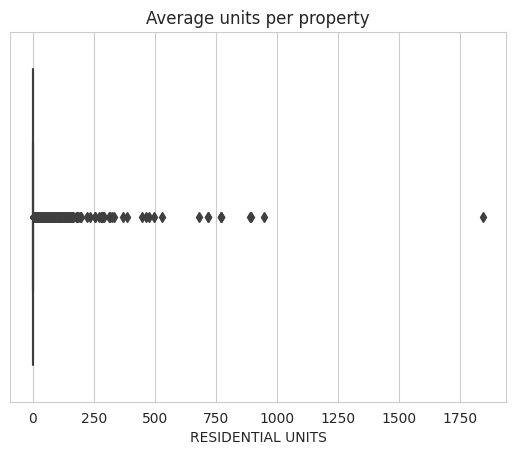

In [42]:
# The dataset seem to have lots of outliers, mainly due to commercial property sales
sns.boxplot(x='RESIDENTIAL UNITS',data=hsales)
plt.title('Average units per property')
plt.show()
#print('not included:', hsales[hsales['RESIDENTIAL UNITS']>10].shape[0], 'properties')

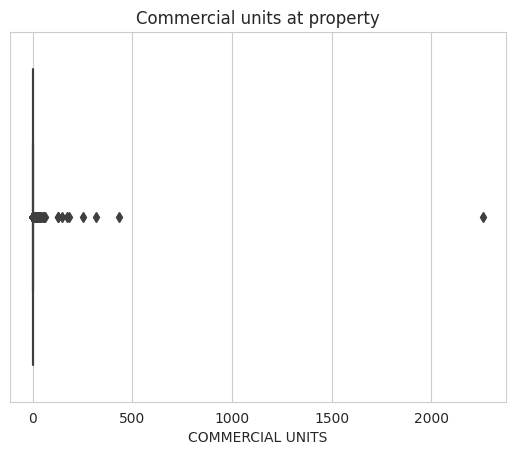

In [43]:
sns.boxplot(x='COMMERCIAL UNITS',data=hsales)
plt.title('Commercial units at property')
plt.show()
#print('not included:', hsales[hsales['COMMERCIAL UNITS']>20].shape[0], 'properties')

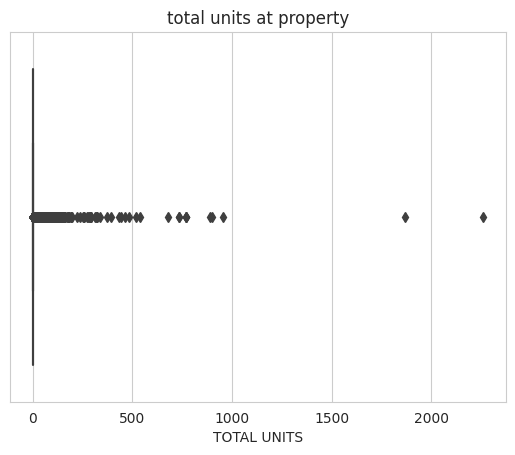

In [44]:
sns.boxplot(x='TOTAL UNITS',data=hsales)
plt.title('total units at property')
plt.show()
#print('not included:', hsales[hsales['TOTAL UNITS']>10].shape[0], 'properties')

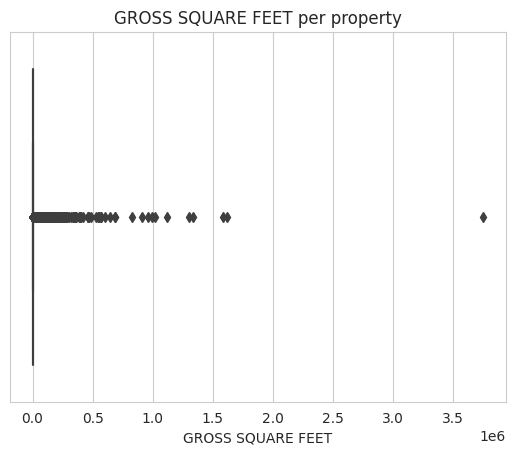

In [45]:
sns.boxplot(x='GROSS SQUARE FEET',data=hsales)
plt.title('GROSS SQUARE FEET per property')
plt.show()
#print('not included:', hsales[hsales['GROSS SQUARE FEET']>20000].shape[0], 'properties')

In [46]:
print("Uneqaul values for total units:", (hsales["TOTAL UNITS"] != hsales['COMMERCIAL UNITS'] + hsales['RESIDENTIAL UNITS']).sum())

Uneqaul values for total units: 981


In [47]:
hsales[hsales["TOTAL UNITS"] != hsales['COMMERCIAL UNITS'] + hsales['RESIDENTIAL UNITS']]['TOTAL UNITS'].value_counts()

TOTAL UNITS
1      963
2        9
3        4
14       1
24       1
4        1
9        1
117      1
Name: count, dtype: int64

These uneqaul values for total unit counts are mostly equal to 1 which might mean they are not residential or commercial units.

In [48]:
hsales[(hsales["TOTAL UNITS"] != hsales['COMMERCIAL UNITS'] + hsales['RESIDENTIAL UNITS']) & (hsales["TOTAL UNITS"]==1)]['BUILDING CLASS CATEGORY'].value_counts()[:5]

BUILDING CLASS CATEGORY
44 CONDO PARKING                               696
47 CONDO NON-BUSINESS STORAGE                  100
43 CONDO OFFICE BUILDINGS                       51
46 CONDO STORE BUILDINGS                        41
48 CONDO TERRACES/GARDENS/CABANAS               31
Name: count, dtype: int64

As we can observe those properties with 1 total units but with no residential or commercial units are parking, office or storages.

For visualization purposes, we will treat outliers seperately.

In [49]:
dataset = hsales[(hsales['COMMERCIAL UNITS']<20) & (hsales['TOTAL UNITS']<50) & (hsales['SALE PRICE']<5000000) & (hsales['SALE PRICE']>100000) & (hsales['GROSS SQUARE FEET']>0)]

Text(0.5, 1.0, 'Commercial Units vs Sale Price')

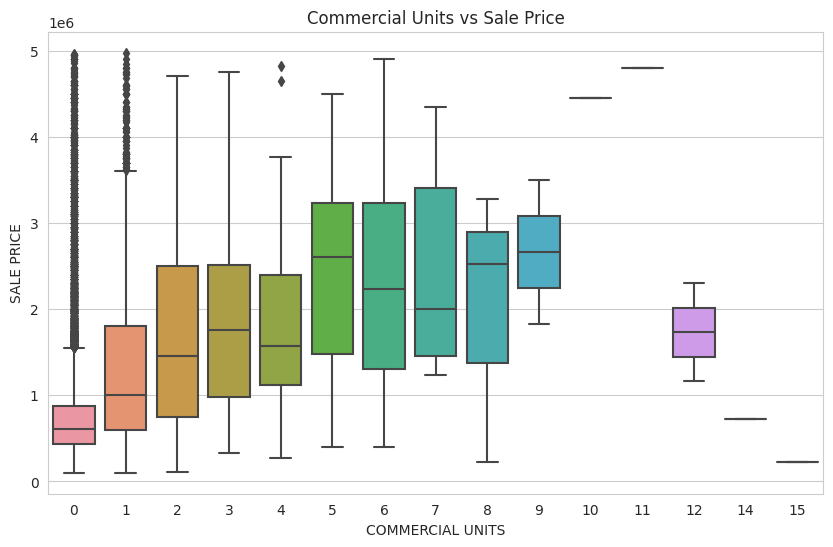

In [50]:
plt.figure(figsize=(10,6))
sns.boxplot(x='COMMERCIAL UNITS', y="SALE PRICE", data=dataset)
plt.title('Commercial Units vs Sale Price')

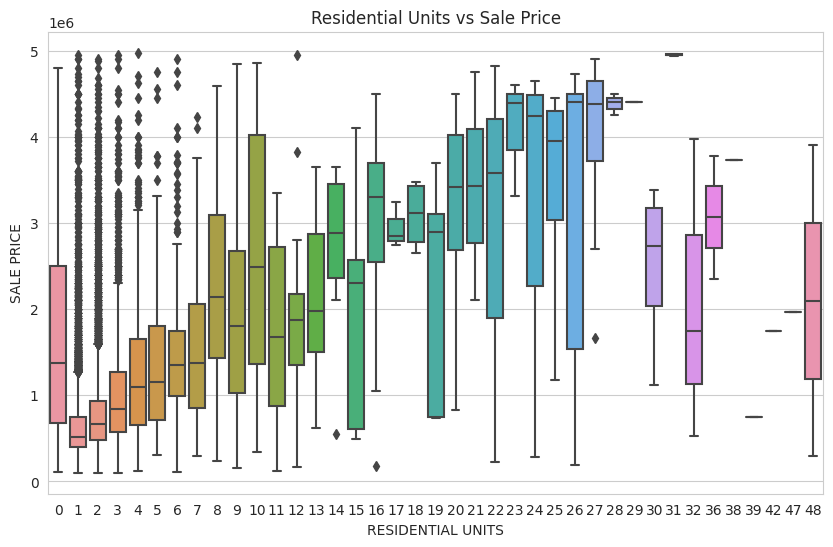

In [51]:
plt.figure(figsize=(10,6))
sns.boxplot(x='RESIDENTIAL UNITS', y='SALE PRICE', data=dataset)
plt.title('Residential Units vs Sale Price')
plt.show()

In [52]:
dataset[dataset['YEAR BUILT']<1800]['YEAR BUILT'].value_counts()

YEAR BUILT
0    9
Name: count, dtype: int64

In [53]:
dataset[dataset['YEAR BUILT']<1800]['BUILDING CLASS CATEGORY'].value_counts()[:15]

BUILDING CLASS CATEGORY
07 RENTALS - WALKUP APARTMENTS                 2
03 THREE FAMILY DWELLINGS                      2
02 TWO FAMILY DWELLINGS                        2
01 ONE FAMILY DWELLINGS                        1
08 RENTALS - ELEVATOR APARTMENTS               1
41 TAX CLASS 4 - OTHER                         1
46 CONDO STORE BUILDINGS                       0
37 RELIGIOUS FACILITIES                        0
48 CONDO TERRACES/GARDENS/CABANAS              0
31 COMMERCIAL VACANT LAND                      0
32 HOSPITAL AND HEALTH FACILITIES              0
33 EDUCATIONAL FACILITIES                      0
34 THEATRES                                    0
35 INDOOR PUBLIC AND CULTURAL FACILITIES       0
36 OUTDOOR RECREATIONAL FACILITIES             0
Name: count, dtype: int64

Above table brings some new insight into why some properties do not have a year or number of units in them. These are vacant lands, elevators, parking and garages. The question is, do they still have addresses?

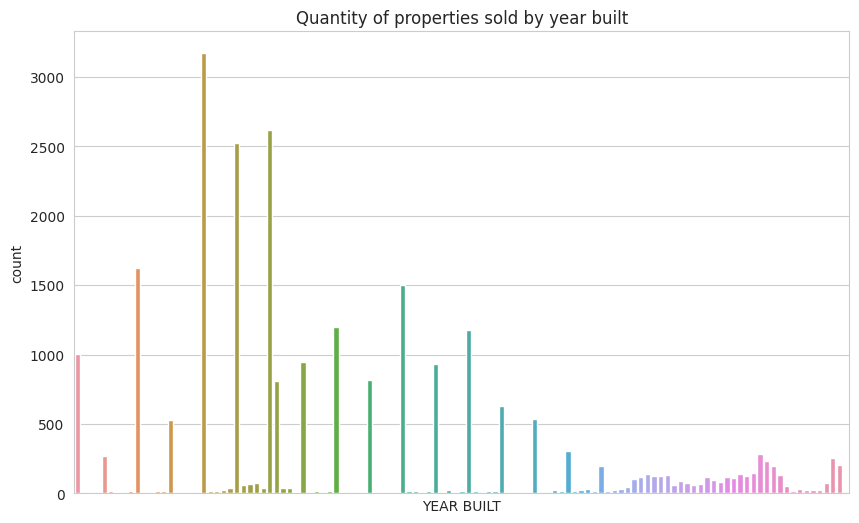

In [54]:
plt.figure(figsize=(10,6))
plotd=sns.countplot(x=dataset[dataset['YEAR BUILT']>1900]['YEAR BUILT'])
#tick_spacing=1 # set spacing for each tick
#plotd.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
#plotd.set_xlim([1900, 2020])
plt.tick_params(labelbottom=False)
plt.xticks(rotation=30) 
plt.title("Quantity of properties sold by year built")
plt.show()

Most of the properties were built around 1920s.[](http://)

<AxesSubplot: xlabel='YEAR BUILT', ylabel='SALE PRICE'>

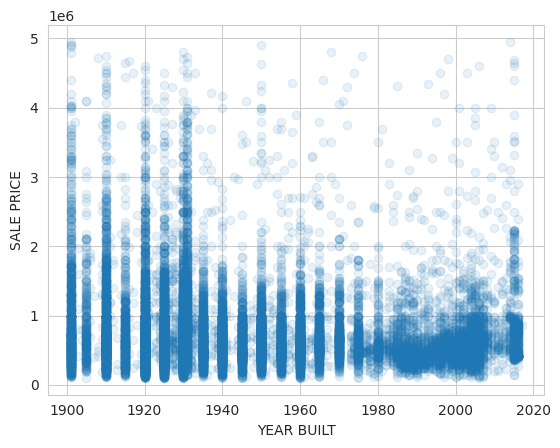

In [55]:
sns.regplot(x='YEAR BUILT', y='SALE PRICE', data=dataset[dataset['YEAR BUILT']>1900][dataset['RESIDENTIAL UNITS']<=5], fit_reg=False, scatter_kws={'alpha':0.1})

* Properties built before 1940 are higher in price.

In [57]:
if 0:
    dataset[dataset['YEAR BUILT']>1900][dataset['RESIDENTIAL UNITS']<=5].plot.scatter(x='YEAR BUILT', y='SALE PRICE', c='RESIDENTIAL UNITS', cmap='coolwarm',figsize=(12,8),s=dataset[dataset['YEAR BUILT']>1900][dataset['RESIDENTIAL UNITS']<=5]['RESIDENTIAL UNITS']*10)
    plt.title('Sales Price vs year. bubble size for units')
    plt.show()

New properties  built after 2000 are sold for relatively cheaper prices compared to houses built in early 1900s.

In [59]:
if 0:
    dataset[dataset['YEAR BUILT']>1900][dataset['RESIDENTIAL UNITS']<=5].plot.scatter(x='YEAR BUILT', y='SALE PRICE', c='GROSS SQUARE FEET', cmap='coolwarm',figsize=(12,8),s=dataset[dataset['YEAR BUILT']>1900][dataset['RESIDENTIAL UNITS']<=5]['GROSS SQUARE FEET']*.008)
    plt.title('Sales Price vs year. bubble size for gross square feet')
    plt.show()

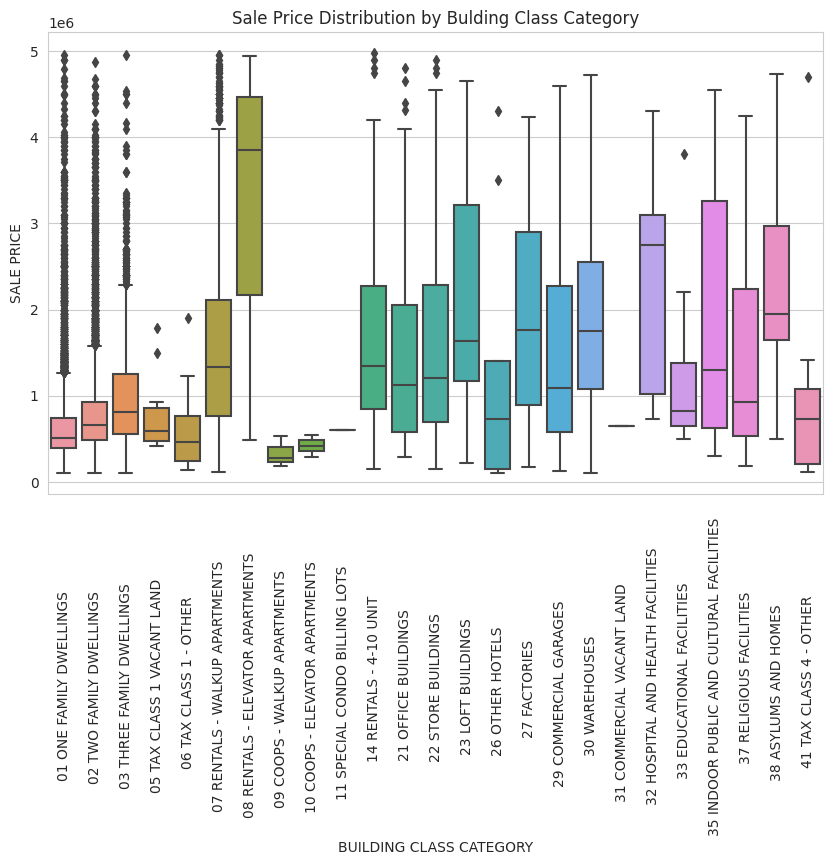

In [60]:
plt.figure(figsize=(10,6))
order = sorted(dataset['BUILDING CLASS CATEGORY'].unique())
sns.boxplot(x='BUILDING CLASS CATEGORY', y='SALE PRICE', data=dataset, order=order)
plt.xticks(rotation=90)
plt.title('Sale Price Distribution by Bulding Class Category')
plt.show()

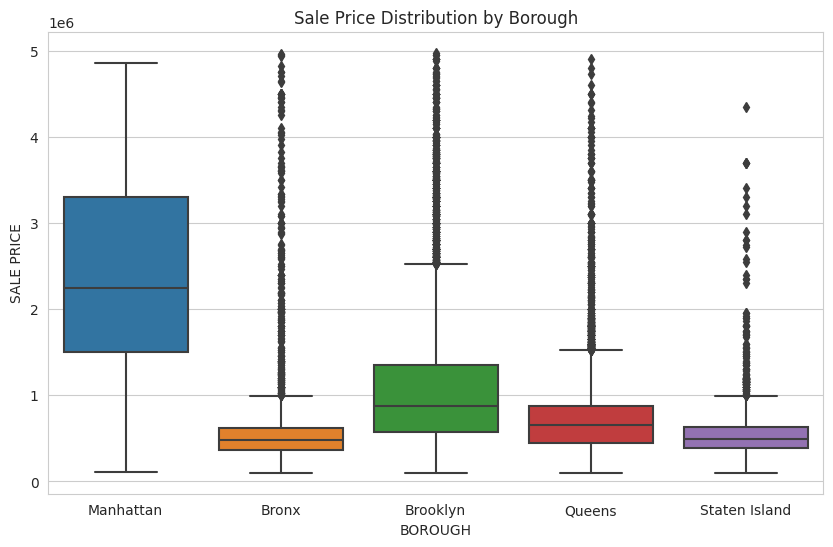

In [61]:
# Sales prices by borough
plt.figure(figsize=(10,6))
sns.boxplot(x='BOROUGH', y='SALE PRICE', data=dataset)
plt.title('Sale Price Distribution by Borough')
plt.show()

Most expensive properties are located in Manhattan with median sale price of over 2 million USD for a property. 
Relatively cheaper properties are in Bronx with median property prices of 500,000 USD.

# Map analysis

In [62]:
import folium # library for interactive map drawing

In [63]:
# from geopy.geocoders import Nominatim # get longitude and latitude based on the address
# def get_lonlat(str_):
#     geolocator = Nominatim()
#     location = geolocator.geocode(str_, country_codes="US")
#     try:
#         return location.latitude, location.longitude
#     except:
#         return np.nan, np.nan

# import requests
# response = requests.get('https://maps.googleapis.com/maps/api/geocode/json?address=1600+Amphitheatre+Parkway,+Mountain+View,+CA')
# resp_json_payload = response.json()
# print(resp_json_payload)

# too many requests
# lonlat = []
# for val in addresses['ADDRESS']:
#     locatn = get_lonlat(val)
#     #print(val, locatn)
#     lonlat.append(locatn)
# lonlat=pd.DataFrame(lonlat, columns=["lon","lat"])
# lonlat.to_csv(path_or_buf="/kaggle/working/lonlat.csv",index=False)
# print("saved")

In [84]:
zipcodes = dataset[hsales["ZIP CODE"]>0]
zipcodes['ZIP']=zipcodes['ZIP CODE'].astype(str) # zipcodes should be str type because geojson file zipcodes are read as str 

In [85]:
boroughs = zipcodes[['ZIP','BOROUGH']]
boroughs.drop_duplicates('ZIP', inplace=True)

In [106]:
# Check for non-numeric values in string columns
string_columns = zipcodes.select_dtypes(include=['object']).columns
non_numeric_values = zipcodes[string_columns].apply(lambda x: x.str.contains(r'\D', na=False)).any()
non_numeric_cols = non_numeric_values[non_numeric_values].index.tolist()
print("Columns with non-numeric values:")
print(non_numeric_cols)

Columns with non-numeric values:
['BOROUGH', 'ADDRESS', 'APARTMENT NUMBER']


In [107]:
# Get the list of numeric columns
numeric_cols = zipcodes_numeric.select_dtypes(include=np.number).columns
numeric_cols

Index(['BLOCK', 'LOT', 'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS',
       'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'SALE PRICE', 'ZIP'],
      dtype='object')

In [115]:
boroughs['ZIP'].unique()

array(['10009', '10011', '10001', '10002', '10013', '10036', '10019',
       '10003', '10018', '10010', '10014', '10030', '10031', '10027',
       '10037', '10035', '10026', '10039', '10029', '10032', '10463',
       '10034', '10025', '10022', '10016', '10021', '10075', '10065',
       '10128', '10028', '10024', '10033', '10040', '10457', '10458',
       '10451', '10456', '10469', '10466', '10475', '10468', '10467',
       '10460', '10473', '10472', '10464', '10803', '10465', '10471',
       '10453', '10452', '10474', '10455', '10462', '10461', '10459',
       '10454', '10470', '11228', '11214', '11220', '11209', '11219',
       '11221', '11233', '11213', '11206', '11216', '11205', '11238',
       '11204', '11234', '11217', '11201', '11218', '11232', '11230',
       '11235', '11212', '11237', '11207', '11236', '11231', '11224',
       '11225', '11208', '11226', '11210', '11203', '11229', '11215',
       '11223', '11222', '11211', '11239', '11249', '11370', '11691',
       '11692', '111

In [117]:
us_zipcodes = pd.read_csv("uszipcodes_geodata.txt", delimiter=',', dtype=str)

# mio
# Check for non-numeric values in the 'ZIP' column
non_numeric_zips = zipcodes[~zipcodes['ZIP'].astype(str).str.isdigit()]['ZIP'].unique()
print("Non-numeric ZIP codes:", non_numeric_zips)

# Remove rows with non-numeric ZIP codes
zipcodes_numeric = zipcodes[zipcodes['ZIP'].astype(str).str.isdigit()]

# Convert 'ZIP' column to integer
zipcodes_numeric['ZIP'] = zipcodes_numeric['ZIP'].astype(int)

# Retry the aggregation process
zipcodes_agg = zipcodes_numeric.groupby('ZIP')[numeric_cols].mean()

# Reset the index of zipcodes_agg without making ZIP the index
zipcodes_agg.reset_index(drop=True, inplace=True)

us_zipcodes['ZIP'] = us_zipcodes['ZIP'].astype(int)
zipcodes_agg['ZIP'] = zipcodes_agg['ZIP'].astype(int)
boroughs['ZIP'] = boroughs['ZIP'].astype(int)

# Merge with other data (assuming 'us_zipcodes' and 'boroughs' are DataFrames)
zipcodes_agg = pd.merge(zipcodes_agg, us_zipcodes, how='left', on='ZIP')
zipcodes_agg = pd.merge(zipcodes_agg, boroughs, how='left', on='ZIP')

# Assuming there's a missing latitude value at index 116, you can assign it as follows:
zipcodes_agg.loc[116, 'LAT'] = "40.6933"

Non-numeric ZIP codes: []


In [119]:
from folium.plugins import MarkerCluster # for clustering the markers
map = folium.Map(location=[40.693943, -73.985880], default_zoom_start=12)
map.choropleth(geo_data="nyc-zip-code-tabulation-areas-polygons.geojson", # I found this NYC zipcode boundaries by googling 
             data=zipcodes_agg, # my dataset
             columns=['ZIP', 'SALE PRICE'], # zip code is here for matching the geojson zipcode, sales price is the column that changes the color of zipcode areas
             key_on='feature.properties.postalCode', # this path contains zipcodes in str type, this zipcodes should match with our ZIP CODE column
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.3,
             legend_name='SALE PRICE')

if 0: # TODO !!! fix code below, so each ZIP has latitude
    # add a marker for every record in the filtered data, use a clustered view
    marker_cluster = MarkerCluster().add_to(map) # create marker clusters
    for i in range(zipcodes_agg.shape[0]):
        location = [zipcodes_agg['LAT'][i],zipcodes_agg['LNG'][i]]
        tooltip = "Zipcode:{}<br> Borough: {}<br> Click for more".format(zipcodes_agg["ZIP"][i], zipcodes_agg['BOROUGH'][i])
        folium.Marker(location, 
                      popup="""<i>Mean sales price: </i> <br> <b>${}</b> <br>
                      <i>mean total units: </i><b><br>{}</b><br>
                      <i>mean square feet: </i><b><br>{}</b><br>""".format(round(zipcodes_agg['SALE PRICE'][i],2), round(zipcodes_agg['TOTAL UNITS'][i],2), round(zipcodes_agg['GROSS SQUARE FEET'][i],2)), 
                      tooltip=tooltip).add_to(marker_cluster)
map

The interactive map shows detailed average prices for each zip code. The most expensive zip codes are 10001 and 10016, 10025 which are located in Manhattan.

In [121]:
map = folium.Map(location=[40.693943, -73.985880], default_zoom_start=12)
map.choropleth(geo_data="nyc-zip-code-tabulation-areas-polygons.geojson", # I found this NYC zipcode boundaries by googling 
             data=zipcodes, # my dataset
             columns=['ZIP', 'SALE PRICE'], # zip code is here for matching the geojson zipcode, sales price is the column that changes the color of zipcode areas
             key_on='feature.properties.postalCode', # this path contains zipcodes in str type, this zipcodes should match with our ZIP CODE column
             fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
             legend_name='SALE PRICE')

# add a marker for every record in the filtered data, use a clustered view
# marker_cluster = MarkerCluster().add_to(map) # create marker clusters
# for i in range(zipcodes_agg.shape[0]):
#     location = [zipcodes_agg['LAT'][i],zipcodes_agg['LNG'][i]]
#     tooltip = "Zipcode:{}<br> Borough: {}<br> Click for more".format(zipcodes_agg["ZIP"][i], zipcodes_agg['BOROUGH'][i])
#     folium.Marker(location, 
#                   popup="""<i>Mean sales price: </i> <br> <b>${}</b> <br>
#                   <i>mean total units: </i><b><br>{}</b><br>
#                   <i>mean square feet: </i><b><br>{}</b><br>""".format(round(zipcodes_agg['SALE PRICE'][i],2), round(zipcodes_agg['TOTAL UNITS'][i],2), round(zipcodes_agg['GROSS SQUARE FEET'][i],2)), 
#                   tooltip=tooltip).add_to(marker_cluster)
map

In [ ]:
# map.save('mymap.html')

More map analysis coming soon...